# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl


### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [2]:
# from lightning.pytorch import Trainer           # or pytorch_lightning.Trainer
# from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# # --- callbacks -----------------------------------------------------------
# early_stop = EarlyStopping(
#     monitor="val/loss",   # metric Lightning logs every val step/epoch
#     mode="min",           # want the *lowest* val/loss
#     patience=30,           # epochs to wait after last improvement
#     min_delta=0.0,        # ignore tiny improvements
#     verbose=True,         # log a message when it triggers
# )

# ckpt = ModelCheckpoint(
#     dirpath="checkpoints",
#     filename="best-{epoch:02d}-{val_loss:.4f}",
#     monitor="val/loss",
#     mode="min",
#     save_top_k=1,
# )

In [3]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 48,
        "num_workers": 16,
    },
    "model": {
        "type": "improved_UNet",
        "kernel_size": 3,
        "base": 64,
        "dropout_rate": 0.1
    },
    "training": {
        "lr": 5e-4,
        "wd": 2e-4
    },
    "trainer": {
        "max_epochs": 20,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "log_every_n_steps": 25
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

In [4]:
# # Best performance

# #NOTE Change the data directory according to where you have your zarr files stored
# config = {
#     "data": {
#         "path": "kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
#         "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
#         "output_vars": ["tas", "pr"],
#         "target_member_id": 0,
#         "train_ssps": ["ssp126", "ssp370", "ssp585"],
#         "test_ssp": "ssp245",
#         "test_months": 360,
#         "batch_size": 64,
#         "num_workers": 4,
#     },
#     "model": {
#         "type": "simple_cnn",
#         "kernel_size": 8,
#         "init_dim": 64,
#         "depth": 16,
#         "dropout_rate": 0.1,
#     },
#     "training": {
#         "lr": 1e-3,
#         "wd": 5e-4
#     },
#     "trainer": {
#         "max_epochs": 100,
#         "accelerator": "auto",
#         "devices": "auto",
#         "precision": 32,
#         "deterministic": True,
#         "num_sanity_val_steps": 0,
#         "callbacks": [early_stop, ckpt],
#     },
#     "seed": 42,
# }
# pl.seed_everything(config["seed"])  # Set seed for reproducibility

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [5]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [6]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.skip = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.skip = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         identity = x
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.skip(identity)
#         return self.relu(out)

# class SimpleCNN(nn.Module):
#     def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
#         super().__init__()
#         self.initial = nn.Sequential(
#             nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
#             nn.BatchNorm2d(init_dim),
#             nn.ReLU(inplace=True),
#         )
#         self.res_blocks = nn.ModuleList()
#         current_dim = init_dim
#         for i in range(depth):
#             out_dim = current_dim * 2 if i < depth - 1 else current_dim
#             self.res_blocks.append(ResidualBlock(current_dim, out_dim))
#             if i < depth - 1:
#                 current_dim *= 2
#         self.dropout = nn.Dropout2d(dropout_rate)
#         self.final = nn.Sequential(
#             nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
#             nn.BatchNorm2d(current_dim // 2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
#         )

#     def forward(self, x):
#         x = self.initial(x)
#         for res_block in self.res_blocks:
#             x = res_block(x)
#         return self.final(self.dropout(x))


### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [7]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data): # default
        return data * self.std_out + self.mean_out
        
    def inverse_transform_input(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, 5, 48, 72)  still on the GPU
        mu  = torch.as_tensor(dm.normalizer.mean_in, device=x.device)[None, :, None, None]
        std = torch.as_tensor(dm.normalizer.std_in , device=x.device)[None, :, None, None]
        return x * std + mu


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [8]:
class ClimateDataset(Dataset):
    """
    Returns a 12-month window of forcings (shape: 12×5×H×W)
    and the target (2×H×W) for the last month in that window.
    """
    def __init__(self, inputs, outputs, seq_len: int = 12, output_is_normalized=True):
        assert seq_len >= 1
        self.x = inputs
        self.y = outputs
        self.seq_len = seq_len
        self.size = len(inputs) - (seq_len - 1)
        print(f"Creating dataset with {self.size} samples...")

        x_np = self.x.compute()
        y_np = self.y.compute()

        self.x = torch.from_numpy(x_np).float()
        self.y = torch.from_numpy(y_np).float()

        if output_is_normalized:
            if torch.isnan(self.x).any() or torch.isnan(self.y).any():
                raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        start = idx
        end   = idx + self.seq_len
        x_win = self.x[start:end] # (12, 5, H, W)
        y_t   = self.y[end - 1] # (2,  H, W)
        return torch.as_tensor(x_win), torch.as_tensor(y_t)


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        # val_split=0.1,
        test_months=360,
        batch_size=32,
        num_workers=0, # default = 0
        seq_len = 12, # not from default 
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        # self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seq_len = seq_len # not from default 
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def log_transform_pr(arr):
            """
            arr : dask or numpy array (N, 2, H, W)
            channel 1 is precipitation  ->  log1p transform in-place
            """
            arr[..., 1, :, :] = da.log1p(arr[..., 1, :, :])   # works for dask & np
            return arr

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        train_output = log_transform_pr(train_output)
        val_output   = log_transform_pr(val_output)

        test_input, test_output = load_ssp(self.test_ssp)
        test_output = log_transform_pr(test_output)

        # print("train_output shape after concat :", train_output.shape)
        # print("output_vars :", self.output_vars)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        # mean_out=da.nanmean(train_output, axis=(0, 2, 3)).compute()
        # std_out=da.nanstd(train_output, axis=(0, 2, 3)).compute()

        # print("tas mean, std :", mean_out[0], std_out[0])   # ≈ 288 K, 20–25 K
        # print("pr  mean, std :", mean_out[1], std_out[1])   # ≈   2 mm/d, ~2 mm/d

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        # test_input, test_output = load_ssp(self.test_ssp)
        window_pad  = self.seq_len - 1
        test_input = test_input[-(self.test_months + window_pad):]
        test_output = test_output[-(self.test_months + window_pad):]

        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm, seq_len=self.seq_len) # seq_len not from default
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm, seq_len=self.seq_len)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, seq_len=self.seq_len, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

In [9]:
# Data Preperation

In [10]:
# # ------------------------------------------
# # Jupyter cell 1 – set up the DataModule
# # ------------------------------------------
# import yaml, torch, matplotlib.pyplot as plt

# # ---- load your config (or inline a dict) ----
# # with open("configs/base.yaml") as f:
# #     cfg = yaml.safe_load(f)

# dm = ClimateDataModule(**config["data"], seq_len=12)
# dm.prepare_data()
# dm.setup("fit")        # creates train/val datasets

# train_loader = dm.train_dataloader()
# lat, lon = dm.get_coords()
# lat_grid, lon_grid = torch.meshgrid(
#     torch.tensor(lat), torch.tensor(lon), indexing="ij")

# # get one batch (B, 12, 5, H, W)  & physical units
# x, y  = next(iter(train_loader))
# x_phys = dm.normalizer.inverse_transform_input (x.clone())
# y_phys = dm.normalizer.inverse_transform_output(y.clone())

# print("batch tensor shapes:", x.shape, y.shape)


In [11]:
# # ------------------------------------------
# # Jupyter cell 2 – histograms of the 5 forcings
# # ------------------------------------------
# forcing_names = config["data"]["input_vars"]          # ['CO2','SO2',...]
# fig, ax = plt.subplots(1, 5, figsize=(20, 3))
# for i, name in enumerate(forcing_names):
#     ax[i].hist(x[:, :, i].flatten(), bins=80, density=True, alpha=0.7)
#     ax[i].set_title(name)
# plt.suptitle("Z-score distribution of forcings in training batch")
# plt.show()


In [12]:
# # ------------------------------------------
# # Jupyter cell 3 – lat-lon maps of a single month
# # ------------------------------------------
# month_idx = 0                     # first month in window
# vmin, vmax = -3, 3                # common z-score limits
# fig, ax = plt.subplots(1, 5, figsize=(20, 3))
# for i, name in enumerate(forcing_names):
#     im = ax[i].pcolormesh(lon, lat, x[0, month_idx, i], vmin=vmin, vmax=vmax, cmap="RdBu_r")
#     ax[i].set_title(f"{name}  (t-11)")
# plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.6)
# plt.suptitle("Spatial pattern of input forcings (one sample)")
# plt.show()


In [13]:
# # ------------------------------------------
# # Jupyter cell 4 – mean ± std maps for tas and pr
# # ------------------------------------------
# import numpy as np
# tas_all = []
# pr_all  = []
# for xb, yb in dm.train_dataloader():
#     y_phys = dm.normalizer.inverse_transform_output(yb.clone())
#     tas_all.append(y_phys[:, 0])   # (B, H, W)
#     pr_all .append(y_phys[:, 1])

# tas_all = torch.cat(tas_all, dim=0).numpy()
# pr_all  = torch.cat(pr_all , dim=0).numpy()

# def plot_mean_std(field, name, units, cmap):
#     mean = field.mean(axis=0)
#     std  = field.std (axis=0)
#     fig, ax = plt.subplots(1, 2, figsize=(10,4))
#     im0 = ax[0].pcolormesh(lon, lat, mean, cmap=cmap); ax[0].set_title(f"{name} mean ({units})")
#     im1 = ax[1].pcolormesh(lon, lat, std , cmap=cmap); ax[1].set_title (f"{name} std ({units})")
#     plt.colorbar(im0, ax=ax[0]); plt.colorbar(im1, ax=ax[1])
#     plt.show()

# plot_mean_std(tas_all, "tas", "K", "coolwarm")
# plot_mean_std(pr_all , "pr",  "mm day⁻¹", "Blues")


### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [14]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, normalizer, learning_rate=8e-4, wd=2e-4): # default lr = 1e-4, no wd
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    # def training_step(self, batch, batch_idx):
    #     x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
    #     # y_hat = self(x)   # Forward pass

    #     # batch = (B, 12, 5, 48, 72)
    #     B, T, C, H, W = x.shape
    #     x = x.view(B, T * C, H, W)
    #     y_hat = self(x)
        
    #     # loss = self.criterion(y_hat, y)  # Calculate loss
    #     # self.log("train/loss", loss)  # Log loss for tracking

    #     import torch.nn.functional as F

    #     # keep existing tas weight = 1
    #     mse_tas = F.mse_loss(y_hat[:,0], y[:,0])
    #     mse_pr  = F.mse_loss(y_hat[:,1], y[:,1])

    #     loss1 = mse_tas + 2.0 * mse_pr
    #     self.log_dict({"train/loss": loss1})

    #     return loss1
        
# ================================================================
# training_step for ImprovedClimateUNet  (tas + pr + rain-mask)
# ================================================================
    def training_step(self, batch, batch_idx):
        """
        batch
        x : (B, 12, 5, 48, 72)  z-scored inputs
        y : (B,  2, 48, 72)     z-scored targets (tas, log1p-pr)
        """
        import torch.nn.functional as F

        # -------- reshape 12-month window → 60 channels --------------
        x, y = batch
        B, T, C, H, W = x.shape
        x = x.view(B, T * C, H, W)                       # (B,60,H,W)

        # -------- forward pass (model returns tuple) -----------------
        (y_hat, mask_hat) = self(x)                      # y_hat (B,2,H,W)

        # # # ─── “cheap” tas→pr coupling  ──────────────────────────────

        # # ===== 1. core regression loss in z-score space ==============
        mse_tas = F.mse_loss(y_hat[:, 0], y[:, 0])
        mse_pr  = F.mse_loss(y_hat[:, 1], y[:, 1])       # log-space pr
        loss_reg = mse_tas + 1.0 * mse_pr                # lambda

        # ===== 2. variance penalty on precipitation ==================
        var_pred = (y_hat[:, 1]).var()
        var_true = (y[:, 1]).var()
        loss_var = 0.01 * torch.abs(var_pred - var_true)

        # ===== 3. auxiliary rain / no-rain mask ======================
        y_phys = self._to_physical(y.detach())
        mask_true = (y_phys[:, 1] > 0.2).float()         # binary mask
        loss_mask = 0.1 * F.binary_cross_entropy(mask_hat.squeeze(1), mask_true)

        # ===== total loss ============================================
        loss = loss_reg + loss_var + loss_mask

        # -------- logging -------------------------------------------
        self.log_dict({
            "train/loss":      loss,
            "train/mse_tas":   mse_tas,
            "train/mse_pr":    mse_pr,
            "train/var_loss":  loss_var,
            "train/mask_bce":  loss_mask,
        }, prog_bar=True)

        # loss = loss_reg

        return loss

    
    def _to_physical(self, z):
        """
        Convert model outputs from normalised to physical units.

        ─ How it avoids the MPS→NumPy crash ─
        •  Hands **NumPy on CPU** to Normalizer (it never gets a GPU tensor).
        •  Converts Normalizer’s result back to a torch.Tensor on z.device.
        """

        # print("For to_physical func, z is: ", z.dtype, type(z), z.device)
        
        import numpy as np
        dev = z.device

        # ── 1. detach & hop to CPU as NumPy ─────────────────────────
        z_np  = z.detach().cpu().numpy()                     # <- plain NumPy array
        y_np  = self.normalizer.inverse_transform_output(z_np)  # Normalizer unchanged

        # ── 2. whatever came back → tensor on original device ──────
        if isinstance(y_np, np.ndarray):
            y_phys = torch.from_numpy(y_np).to(dev)
        else:                           # just in case Normalizer already returns tensor
            y_phys = torch.as_tensor(y_np, device=dev)

        # ── 3. post-processing stays the same ──────────────────────
        y_phys[:, 1] = torch.expm1(y_phys[:, 1])   # pr back to mm/d

        return y_phys



    def validation_step(self, batch, batch_idx):
        import torch.nn.functional as F
        x, y = batch
        B, T, C, H, W = x.shape
        x = x.view(B, T * C, H, W)


        y_hat, mask_hat = self(x)
        mse_tas = F.mse_loss(y_hat[:, 0], y[:, 0])
        mse_pr = F.mse_loss(y_hat[:, 1], y[:, 1])
        loss = mse_tas + 3 * mse_pr
        self.log("val/loss", loss, prog_bar=True)

        y_hat_phys = self._to_physical(y_hat.detach())
        y_phys = self._to_physical(y.detach())

        mask_true = (y_phys[:, 1] > 0.2).float()
        acc = (mask_hat.detach() > 0.5).eq(mask_true).float().mean()
        self.log("val/mask_acc", acc, prog_bar=True)

        y_hat_phys = y_hat_phys.detach().cpu().numpy()
        y_phys = y_phys.detach().cpu().numpy()

        self.val_preds.append(y_hat_phys)
        self.val_targets.append(y_phys)

        # print("For validation_step, before appending, y_hat_phys is: ", y_hat_phys.dtype, type(y_hat_phys))
        # print("For validation_step, before appending, y_phys is: ", y_phys.dtype, type(y_phys))
        # input()
        return loss



    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch                     # targets are dummy zeros
        B, T, C, H, W = x.shape
        x = x.view(B, T * C, H, W)

        y_hat, _ = self(x)               # ignore mask in test
        y_hat_phys = self._to_physical(y_hat.detach())   # tensor, mps

        self.test_preds.append(y_hat_phys.detach().cpu().numpy())
        self.test_targets.append(y.detach().cpu().numpy())


    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [15]:
# datamodule = ClimateDataModule(**config["data"])

# model = SimpleCNN(
#     n_input_channels=len(config["data"]["input_vars"]),
#     n_output_channels=len(config["data"]["output_vars"]),
#     **{k: v for k, v in config["model"].items() if k != "type"}
# )
# lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

# trainer = pl.Trainer(**config["trainer"])
# trainer.fit(lightning_module, datamodule=datamodule)   # Training

In [16]:
# # This is the primary UNet module.

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ConvBNReLU(nn.Sequential):
#     def __init__(self, c_in, c_out, k=3, s=1, p=1):
#         super().__init__(
#             nn.Conv2d(c_in, c_out, k, s, p, bias=False),
#             nn.BatchNorm2d(c_out),
#             nn.ReLU(inplace=True),
#         )

# class SEblock(nn.Module):
#     def __init__(self, c, r=8):
#         super().__init__()
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.fc   = nn.Sequential(
#             nn.Conv2d(c, c // r, 1), nn.ReLU(inplace=True),
#             nn.Conv2d(c // r, c, 1), nn.Sigmoid()
#         )
#     def forward(self, x):
#         w = self.fc(self.pool(x))
#         return x * w


# # ---------- UNet-style encoder–decoder -------------------------------------
# class ClimateUNet(nn.Module):
#     """
#     Deeper, SE-attention UNet for climate emulation.
#     in_ch  =  5  (or T*5 if you flatten a 12-month window to channels)
#     out_ch =  2  (tas, pr) – emitted by two heads
#     """
#     def __init__(self, in_ch: int = 5, base: int = 32):
#         super().__init__()
#         c = base          # 32 → 64 → 128 → 256
#         # Encoder
#         self.enc1 = nn.Sequential(ConvBNReLU(in_ch,  c), SEblock(c))
#         self.enc2 = nn.Sequential(ConvBNReLU(c,   c*2, s=2), SEblock(c*2))
#         self.enc3 = nn.Sequential(ConvBNReLU(c*2, c*4, s=2), SEblock(c*4))
#         self.enc4 = nn.Sequential(ConvBNReLU(c*4, c*8, s=2), SEblock(c*8))
#         # Decoder
#         self.up3  = nn.ConvTranspose2d(c*8, c*4, 2, 2)      # 1/8 → 1/4
#         self.dec3 = ConvBNReLU(c*8, c*4)                     # skip concat
#         self.up2  = nn.ConvTranspose2d(c*4, c*2, 2, 2)      # 1/4 → 1/2
#         self.dec2 = ConvBNReLU(c*4, c*2)
#         self.up1  = nn.ConvTranspose2d(c*2, c,   2, 2)      # 1/2 → 1
#         self.dec1 = ConvBNReLU(c*2, c)
#         # Two variable-specific heads
#         self.head_tas = nn.Conv2d(c, 1, 1)
#         self.head_pr  = nn.Conv2d(c, 1, 1)

#     def forward(self, x):
#         # ---- encoder ----
#         e1 = self.enc1(x)          # (B,c,H, W)
#         e2 = self.enc2(e1)         # (B,2c,H/2,W/2)
#         e3 = self.enc3(e2)         # (B,4c,H/4,W/4)
#         e4 = self.enc4(e3)         # (B,8c,H/8,W/8)
#         # ---- decoder with skips ----
#         d3 = self.dec3(torch.cat([self.up3(e4), e3], dim=1))
#         d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
#         d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
#         # ---- two heads ----
#         tas = self.head_tas(d1)
#         pr  = self.head_pr(d1)
#         return torch.cat([tas, pr], dim=1)   # shape (B,2,H,W)


In [17]:
# # This is the refined UNet module

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # --- Depthwise Separable Convolution Block ---
# class DepthwiseSeparableConvBNReLU(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
#         super().__init__()
#         self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
#         self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
        
#     def forward(self, x):
#         x = self.depthwise(x)
#         x = self.pointwise(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         return x

# # --- SE Block (Squeeze-and-Excitation) ---
# class SEBlock(nn.Module):
#     def __init__(self, channels, reduction=8):
#         super().__init__()
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Conv2d(channels, channels // reduction, kernel_size=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(channels // reduction, channels, kernel_size=1),
#             nn.Sigmoid()
#         )
        
#     def forward(self, x):
#         w = self.fc(self.pool(x))
#         return x * w

# # --- Convolutional Block with BatchNorm and ReLU ---
# class ConvBNReLU(nn.Sequential):
#     def __init__(self, c_in, c_out, k=3, s=1, p=1, use_separable=False):
#         if use_separable:
#             conv_block = DepthwiseSeparableConvBNReLU(c_in, c_out, kernel_size=k, stride=s, padding=p)
#         else:
#             conv_block = nn.Sequential(
#                 nn.Conv2d(c_in, c_out, k, s, p, bias=False),
#                 nn.BatchNorm2d(c_out),
#                 nn.ReLU(inplace=True)
#             )
#         super().__init__(conv_block)

# # --- Upsampling Block: Bilinear upsample then conv ---
# class UpsampleConv(nn.Module):
#     def __init__(self, in_channels, out_channels, scale_factor=2, mode='bilinear'):
#         super().__init__()
#         self.upsample = nn.Upsample(scale_factor=scale_factor, mode=mode, align_corners=True)
#         self.conv = ConvBNReLU(in_channels, out_channels)
    
#     def forward(self, x):
#         x = self.upsample(x)
#         x = self.conv(x)
#         return x

# # --- Refined UNet Model for Climate Emulation ---
# class RefinedClimateUNet(nn.Module):
#     """
#     A refined UNet for climate emulation with SE attention, dropout regularization, and efficient upsampling.
#     in_ch  =  5  (or T*5 if you flatten a 12-month window to channels)
#     out_ch =  2  (e.g., tas, pr) – emitted by two variable-specific heads
#     """
#     def __init__(self, in_ch: int = 60, base: int = 32, use_separable: bool = False, dropout_p: float = 0.1):
#         super().__init__()
#         c = base  # 32 -> 64 -> 128 -> 256
        
#         # Define dropout to be used in the encoder for extra regularization.
#         self.dropout = nn.Dropout2d(p=dropout_p)
        
#         # Encoder
#         self.enc1 = nn.Sequential(
#             ConvBNReLU(in_ch, c, use_separable=use_separable),
#             SEBlock(c)
#         )
#         self.enc2 = nn.Sequential(
#             ConvBNReLU(c, c * 2, s=2, use_separable=use_separable),
#             SEBlock(c * 2)
#         )
#         self.enc3 = nn.Sequential(
#             ConvBNReLU(c * 2, c * 4, s=2, use_separable=use_separable),
#             SEBlock(c * 4)
#         )
#         self.enc4 = nn.Sequential(
#             ConvBNReLU(c * 4, c * 8, s=2, use_separable=use_separable),
#             SEBlock(c * 8)
#         )
        
#         # Decoder using Upsampling (avoiding transposed convolutions)
#         self.up3 = UpsampleConv(c * 8, c * 4)    # from 1/8 to 1/4 spatially
#         self.dec3 = ConvBNReLU(c * 8, c * 4, use_separable=use_separable)  # after concatenating skip connection
#         self.up2 = UpsampleConv(c * 4, c * 2)      # from 1/4 to 1/2
#         self.dec2 = ConvBNReLU(c * 4, c * 2, use_separable=use_separable)
#         self.up1 = UpsampleConv(c * 2, c)          # from 1/2 to full resolution
#         self.dec1 = ConvBNReLU(c * 2, c, use_separable=use_separable)
        
#         # Two heads for variable-specific outputs
#         self.head_tas = nn.Conv2d(c, 1, kernel_size=1)
#         self.head_pr  = nn.Conv2d(c, 1, kernel_size=1)
    
#     def forward(self, x):
#         # Encoder with dropout regularization
#         e1 = self.dropout(self.enc1(x))         # (B, c, H, W)
#         e2 = self.dropout(self.enc2(e1))          # (B, 2c, H/2, W/2)
#         e3 = self.dropout(self.enc3(e2))          # (B, 4c, H/4, W/4)
#         e4 = self.enc4(e3)                      # (B, 8c, H/8, W/8)
        
#         # Decoder with skip connections
#         d3 = self.up3(e4)                       # (B, 4c, H/4, W/4)
#         d3 = torch.cat([d3, e3], dim=1)          # concatenate along channel dimension
#         d3 = self.dec3(d3)
        
#         d2 = self.up2(d3)                       # (B, 2c, H/2, W/2)
#         d2 = torch.cat([d2, e2], dim=1)
#         d2 = self.dec2(d2)
        
#         d1 = self.up1(d2)                       # (B, c, H, W)
#         d1 = torch.cat([d1, e1], dim=1)
#         d1 = self.dec1(d1)
        
#         # Two variable-specific heads
#         tas = self.head_tas(d1)
#         pr  = self.head_pr(d1)
#         return torch.cat([tas, pr], dim=1)





In [18]:
# ================================================================
#  ImprovedClimateUNet: SE-U-Net + Fourier bottleneck + mask head
# ================================================================

import torch, torch.nn as nn, torch.nn.functional as F
import math

# ---------- (1) spectral convolution ----------------------------
class SpectralConv2d(nn.Module):
    """
    Simple 2-D Fourier layer.
    weight shape : (C_in, C_out, Hm, Wm, 2)  →  complex (C_in, C_out, Hm, Wm)
    """
    def __init__(self, c_in, c_out, modes_h=8, modes_w=12):
        super().__init__()
        self.modes_h, self.modes_w = modes_h, modes_w
        scale = 1 / math.sqrt(c_in * c_out)

        # (Cin, Cout, kx, ky, 2)  last dim is [real, imag]
        self.weight = nn.Parameter(
            scale * torch.randn(c_in, c_out, modes_h, modes_w, 2)
        )

    def compl_mul2d(self, a, b):
        # a: (B, Cin, Hm, Wm)   b: (Cin, Cout, Hm, Wm)
        return torch.einsum("bixy,ioxy->boxy", a, b)

    def forward(self, x):
        B, C, H, W = x.shape
        x_ft = torch.fft.rfft2(x, norm="ortho")

        # clip modes so we never slice beyond array bounds
        mh = min(self.modes_h, H)
        mw = min(self.modes_w, W // 2 + 1)

        weight_cplx = torch.view_as_complex(self.weight)[..., :mh, :mw]

        out_ft = torch.zeros(B, weight_cplx.shape[1], H, W // 2 + 1,
                            dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :mh, :mw] = self.compl_mul2d(
            x_ft[:, :, :mh, :mw], weight_cplx
        )
        return torch.fft.irfft2(out_ft, s=(H, W), norm="ortho")



# ---------- (2) conv helpers ------------------------------------
def conv_bn_relu(cin, cout, k=3, s=1, p=1, dil=1):
    return nn.Sequential(
        nn.Conv2d(cin, cout, k, s, p, dilation=dil, bias=False),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
    )

class SEBlock(nn.Module):
    def __init__(self, c, r=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(c, c//r, 1), nn.ReLU(inplace=True),
            nn.Conv2d(c//r, c, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)


class UpsampleBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = conv_bn_relu(cin, cout)
    def forward(self, x):
        return self.conv(self.up(x))


# ---------- (3) full network ------------------------------------
class ImprovedClimateUNet(nn.Module):
    def __init__(self, in_ch=60, base=32, dropout_p=0.1):
        super().__init__()
        c = base
        self.do = nn.Dropout2d(dropout_p)

        # Encoder (keep resolution after enc2)
        self.enc1 = nn.Sequential(conv_bn_relu(in_ch,  c),    SEBlock(c))          # 48×72
        self.enc2 = nn.Sequential(conv_bn_relu(c,   2*c, s=2), SEBlock(2*c))       # 24×36
        self.enc3 = nn.Sequential(conv_bn_relu(2*c, 4*c, s=2), SEBlock(4*c))       # 12×18
        self.enc4 = nn.Sequential(conv_bn_relu(4*c, 8*c, s=2), SEBlock(8*c))       #  6× 9


        # Fourier bottleneck
        self.fno  = SpectralConv2d(8*c, 8*c)

        # Decoder (H/2 → H) – no pooling inside dec blocks
        self.up3  = UpsampleBlock(8*c, 4*c)
        self.dec3 = conv_bn_relu(8*c, 4*c)
        self.up2  = UpsampleBlock(4*c, 2*c)
        self.dec2 = conv_bn_relu(4*c, 2*c)
        self.up1  = UpsampleBlock(2*c, c)
        self.dec1 = conv_bn_relu(2*c, c)

        # Heads
        self.head_tas  = nn.Conv2d(c, 1, 1)
        self.head_pr   = nn.Conv2d(c, 1, 1)
        self.head_mask = nn.Conv2d(c, 1, 1)   # rain / no-rain

    def forward(self, x):
        # ---------- encoder ----------
        e1 = self.do(self.enc1(x))         # (B,c,H,W)
        e2 = self.do(self.enc2(e1))        # (B,2c,H/2,W/2)
        e3 = self.enc3(e2)                 # keep H/2 via dilation
        e4 = self.enc4(e3)

        # ---------- bottleneck ----------
        z  = self.fno(e4)

        # ---------- decoder ----------
        d3 = self.up3(z)
        d3 = self.dec3(torch.cat([d3, e3], 1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], 1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], 1))

        tas  = self.head_tas(d1)
        pr   = self.head_pr(d1)
        mask = torch.sigmoid(self.head_mask(d1))

        return torch.cat([tas, pr], 1), mask


In [19]:
# datamodule = ClimateDataModule(**config["data"])

# core_U = ClimateUNet(in_ch=60, base=32)

# lightning_mod = ClimateEmulationModule(core_U, datamodule.normalizer, learning_rate=config["training"]["lr"], wd=config["training"]["wd"])

# trainer = pl.Trainer(**config["trainer"])
# trainer.fit(lightning_mod, datamodule=datamodule)

In [20]:
# datamodule = ClimateDataModule(seq_len=12, **config["data"])
# core_RUNet = RefinedClimateUNet(in_ch=60, use_separable=True, dropout_p=0.1)

# lightning_mod1 = ClimateEmulationModule(core_RUNet, datamodule.normalizer, learning_rate=config["training"]["lr"], wd=config["training"]["wd"])

# trainer = pl.Trainer(**config["trainer"])
# trainer.fit(lightning_mod1, datamodule=datamodule)

In [21]:
datamodule = ClimateDataModule(seq_len=12, **config["data"])
core_cnn   = ImprovedClimateUNet(in_ch=12*5)
lightning_module = ClimateEmulationModule(core_cnn, datamodule.normalizer, learning_rate=config["training"]["lr"], wd=config["training"]["wd"])

trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-06-02 01:37:15.613343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748828235.635037   41781 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748828235.641820   41781 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 01:37:15.664992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
T

Creating dataset with 2692 samples...
Creating dataset with 349 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ImprovedClimateUNet | 13.8 M | train
1 | criterion | MSELoss             | 0      | train
----------------------------------------------------------
13.8 M    Trainable params
0         Non-trainable params
13.8 M    Total params
55.143    Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=18.3280, Time-Mean RMSE=17.6327, Time-Stddev MAE=3.5600
[VAL] pr: RMSE=3.6242, Time-Mean RMSE=2.4483, Time-Stddev MAE=2.0627


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.2944, Time-Mean RMSE=2.3869, Time-Stddev MAE=1.0499
[VAL] pr: RMSE=2.5103, Time-Mean RMSE=1.2921, Time-Stddev MAE=1.1195


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.6144, Time-Mean RMSE=1.7603, Time-Stddev MAE=0.7926
[VAL] pr: RMSE=2.2691, Time-Mean RMSE=0.8749, Time-Stddev MAE=0.9554


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3568, Time-Mean RMSE=1.5606, Time-Stddev MAE=0.6902
[VAL] pr: RMSE=2.1982, Time-Mean RMSE=0.8038, Time-Stddev MAE=0.9226


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0922, Time-Mean RMSE=1.3096, Time-Stddev MAE=0.5787
[VAL] pr: RMSE=2.1828, Time-Mean RMSE=0.7777, Time-Stddev MAE=0.9805


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0387, Time-Mean RMSE=1.2362, Time-Stddev MAE=0.6069
[VAL] pr: RMSE=2.1204, Time-Mean RMSE=0.6621, Time-Stddev MAE=0.9206


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0078, Time-Mean RMSE=1.2489, Time-Stddev MAE=0.4962
[VAL] pr: RMSE=2.2069, Time-Mean RMSE=0.8659, Time-Stddev MAE=0.9449


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8884, Time-Mean RMSE=1.1347, Time-Stddev MAE=0.4710
[VAL] pr: RMSE=2.0591, Time-Mean RMSE=0.5546, Time-Stddev MAE=0.8872


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9539, Time-Mean RMSE=1.2422, Time-Stddev MAE=0.4713
[VAL] pr: RMSE=2.0721, Time-Mean RMSE=0.5612, Time-Stddev MAE=0.8920


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9304, Time-Mean RMSE=1.1638, Time-Stddev MAE=0.4302
[VAL] pr: RMSE=2.1026, Time-Mean RMSE=0.6030, Time-Stddev MAE=0.8668


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7741, Time-Mean RMSE=1.0234, Time-Stddev MAE=0.4202
[VAL] pr: RMSE=2.0726, Time-Mean RMSE=0.5908, Time-Stddev MAE=0.7989


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6841, Time-Mean RMSE=0.8984, Time-Stddev MAE=0.4130
[VAL] pr: RMSE=2.0458, Time-Mean RMSE=0.5214, Time-Stddev MAE=0.8115


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7566, Time-Mean RMSE=0.9915, Time-Stddev MAE=0.3949
[VAL] pr: RMSE=2.0208, Time-Mean RMSE=0.4554, Time-Stddev MAE=0.8189


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6879, Time-Mean RMSE=0.9386, Time-Stddev MAE=0.3971
[VAL] pr: RMSE=2.0368, Time-Mean RMSE=0.5211, Time-Stddev MAE=0.8450


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6467, Time-Mean RMSE=0.8344, Time-Stddev MAE=0.3828
[VAL] pr: RMSE=2.0505, Time-Mean RMSE=0.5316, Time-Stddev MAE=0.7862


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6726, Time-Mean RMSE=0.8568, Time-Stddev MAE=0.4065
[VAL] pr: RMSE=2.0254, Time-Mean RMSE=0.4417, Time-Stddev MAE=0.7672


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6855, Time-Mean RMSE=0.8854, Time-Stddev MAE=0.3704
[VAL] pr: RMSE=2.0564, Time-Mean RMSE=0.5579, Time-Stddev MAE=0.8471


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6557, Time-Mean RMSE=0.8153, Time-Stddev MAE=0.3937
[VAL] pr: RMSE=2.0284, Time-Mean RMSE=0.4715, Time-Stddev MAE=0.7667


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7928, Time-Mean RMSE=1.1183, Time-Stddev MAE=0.3811
[VAL] pr: RMSE=2.0455, Time-Mean RMSE=0.5474, Time-Stddev MAE=0.8413


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6039, Time-Mean RMSE=0.8235, Time-Stddev MAE=0.3650
[VAL] pr: RMSE=2.0083, Time-Mean RMSE=0.4435, Time-Stddev MAE=0.7414


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5925, Time-Mean RMSE=0.8253, Time-Stddev MAE=0.3301
[VAL] pr: RMSE=2.0503, Time-Mean RMSE=0.5594, Time-Stddev MAE=0.8642


`Trainer.fit` stopped: `max_epochs=20` reached.


# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [22]:
# x, _ = next(iter(datamodule.test_dataloader()))
# print(x.shape)                  # should be (B, 5, 96, 216)   if B=1 window
#                                 # or  (B, T*5, 96, 216)   if you flatten time

In [23]:
# trainer.test(lightning_mod, datamodule=datamodule)

In [24]:
# trainer.test(lightning_module, datamodule=datamodule) 

In [25]:
trainer.test(lightning_module, datamodule=datamodule) 

/home/z3qi/.local/lib/python3.11/site-packages/zarr/core/group.py:3301: UserWarning: Object at .DS_Store is not recognized as a component of a Zarr hierarchy.
  warnings.warn(


Creating dataset with 2692 samples...
Creating dataset with 349 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.5612, Time-Mean RMSE=290.5172, Time-Stddev MAE=3.6633
[TEST] pr: RMSE=3.9055, Time-Mean RMSE=3.4453, Time-Stddev MAE=1.3018
✅ Submission saved to: submissions/kaggle_submission_20250602_014122.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │    3.9054694175720215     │
│  test/pr/time_mean_rmse   │    3.4452834129333496     │
│   test/pr/time_std_mae    │    1.3018172979354858     │
│       test/tas/rmse       │     290.5611877441406     │
│  test/tas/time_mean_rmse  │     290.5171813964844     │
│   test/tas/time_std_mae   │     3.663261651992798     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.5611877441406,
  'test/tas/time_mean_rmse': 290.5171813964844,
  'test/tas/time_std_mae': 3.663261651992798,
  'test/pr/rmse': 3.9054694175720215,
  'test/pr/time_mean_rmse': 3.4452834129333496,
  'test/pr/time_std_mae': 1.3018172979354858}]

In [26]:
# tas = y_hat_phys[:, 0].reshape(-1)
# pr  = y_hat_phys[:, 1].reshape(-1)

# df = pd.DataFrame({
#         "time": t.repeat(96*216),
#         "lat" : lat_grid.flatten(),
#         "lon" : lon_grid.flatten(),
#         "tas" : tas,
#         "pr"  : pr
# })
# len(df)

### Plotting Utils


In [27]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


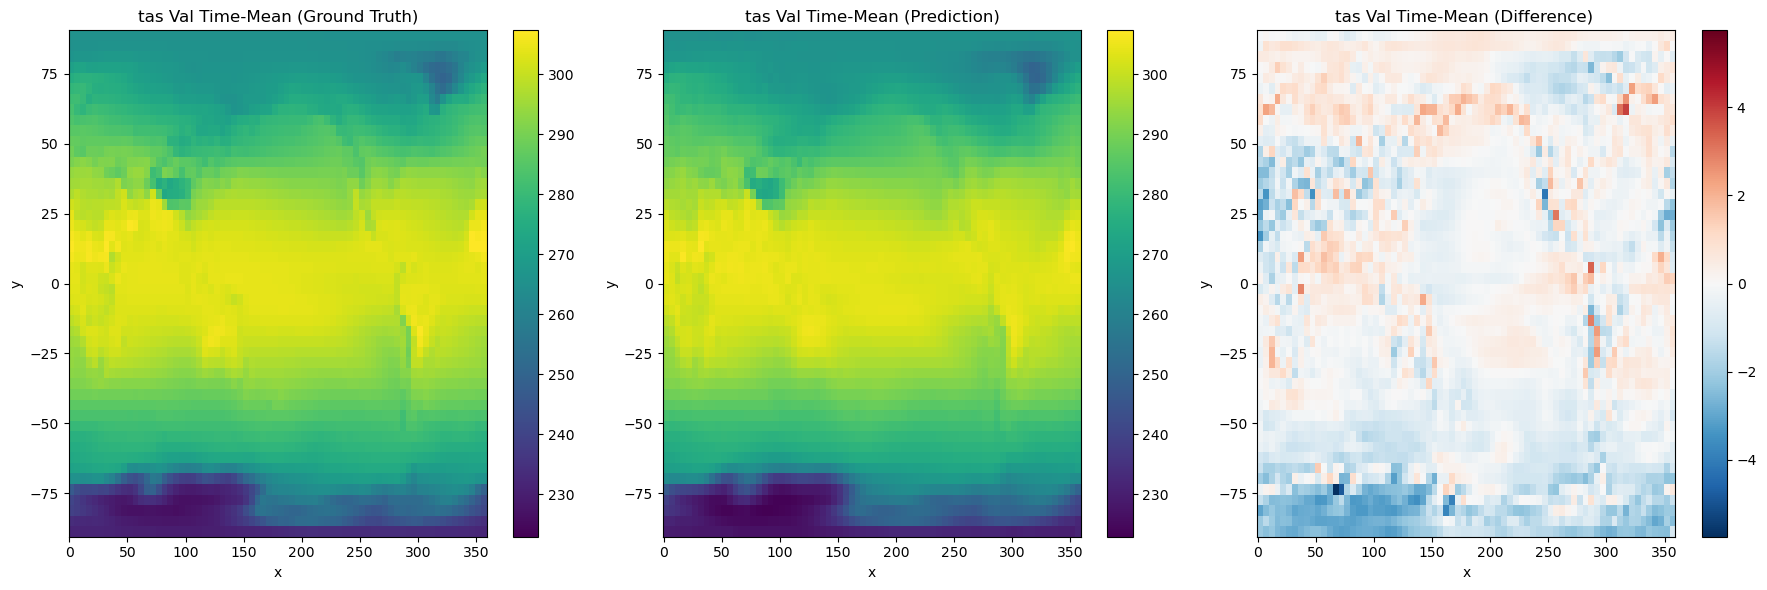

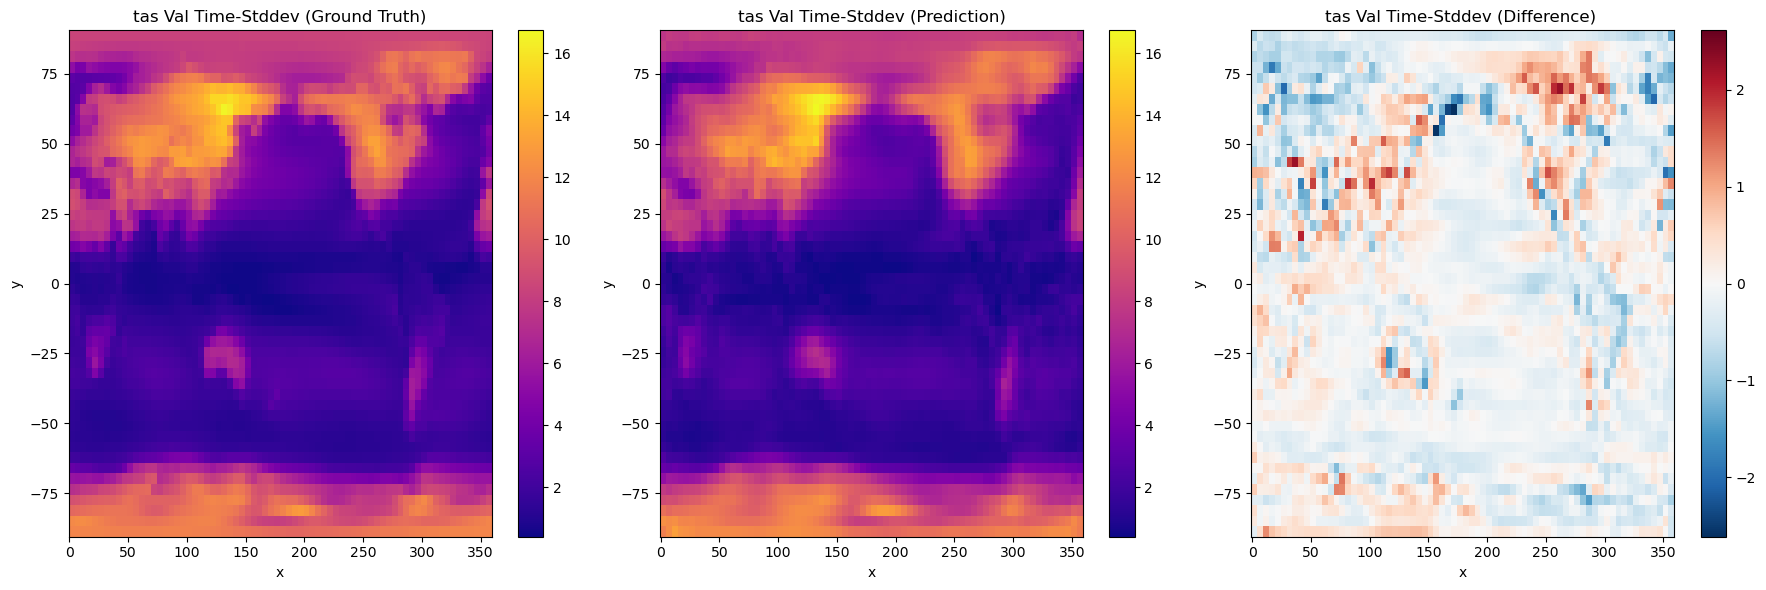

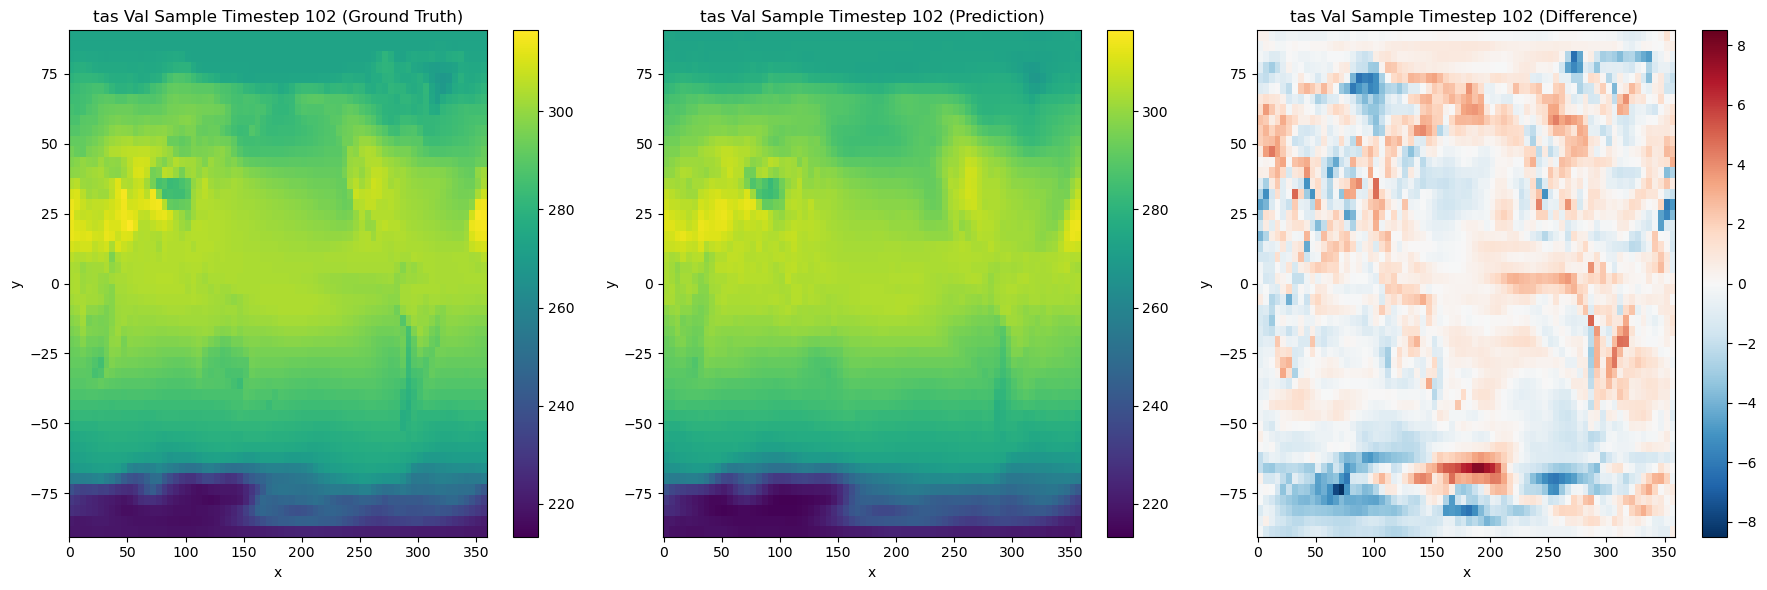

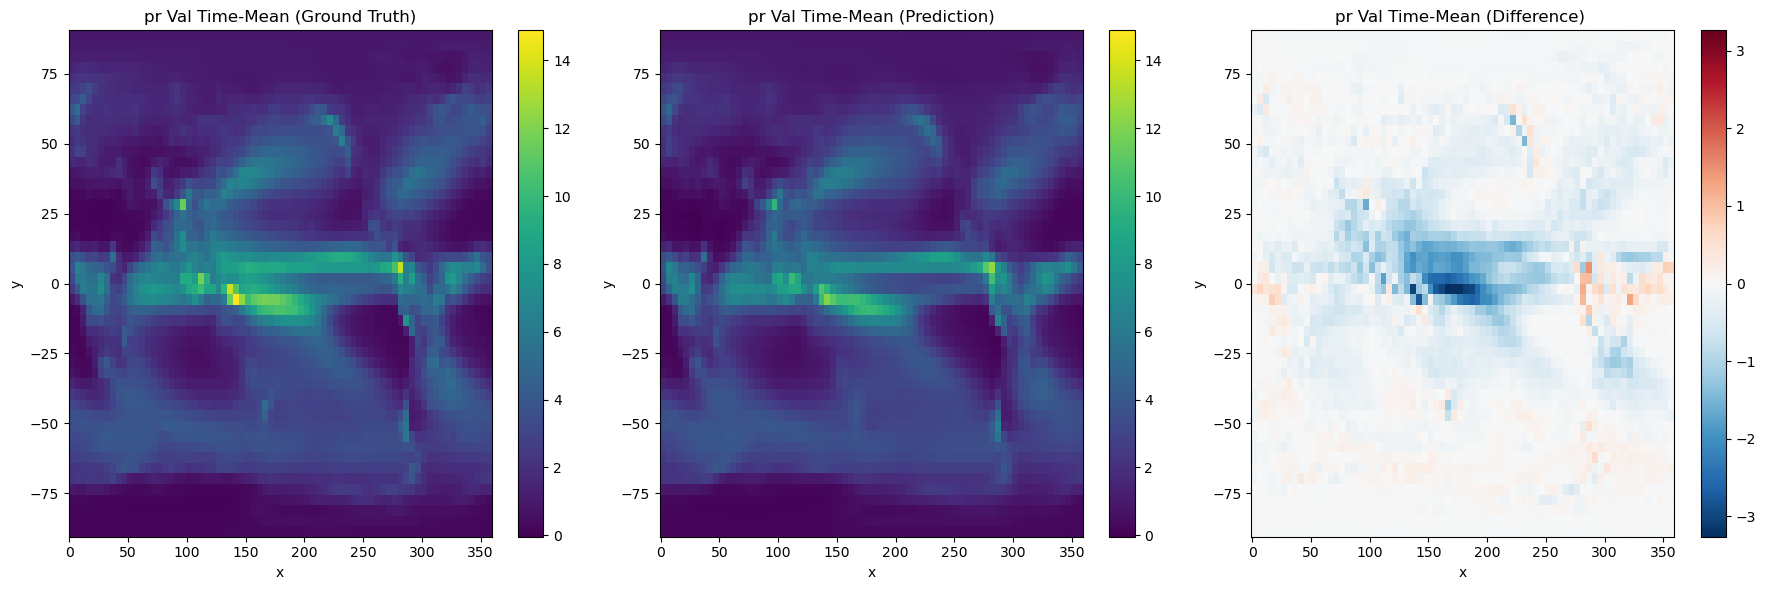

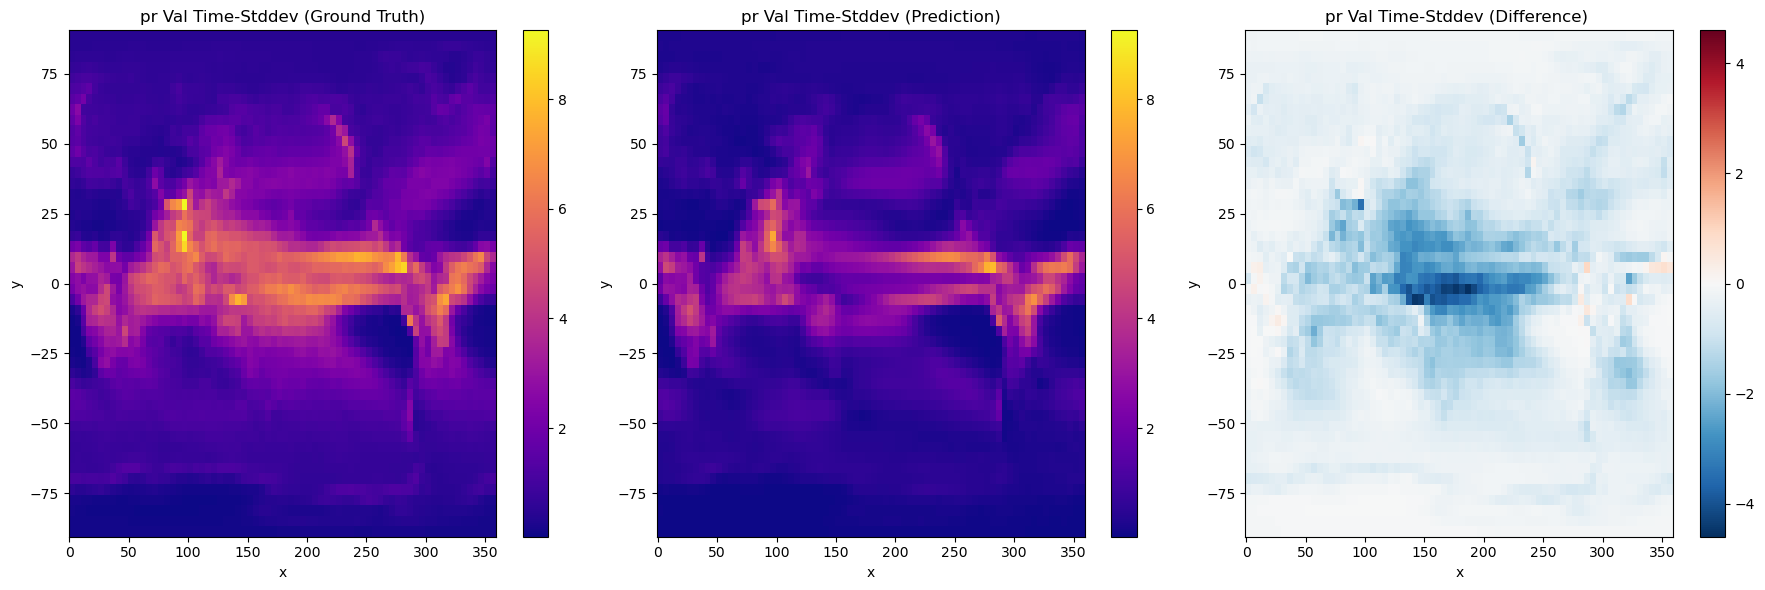

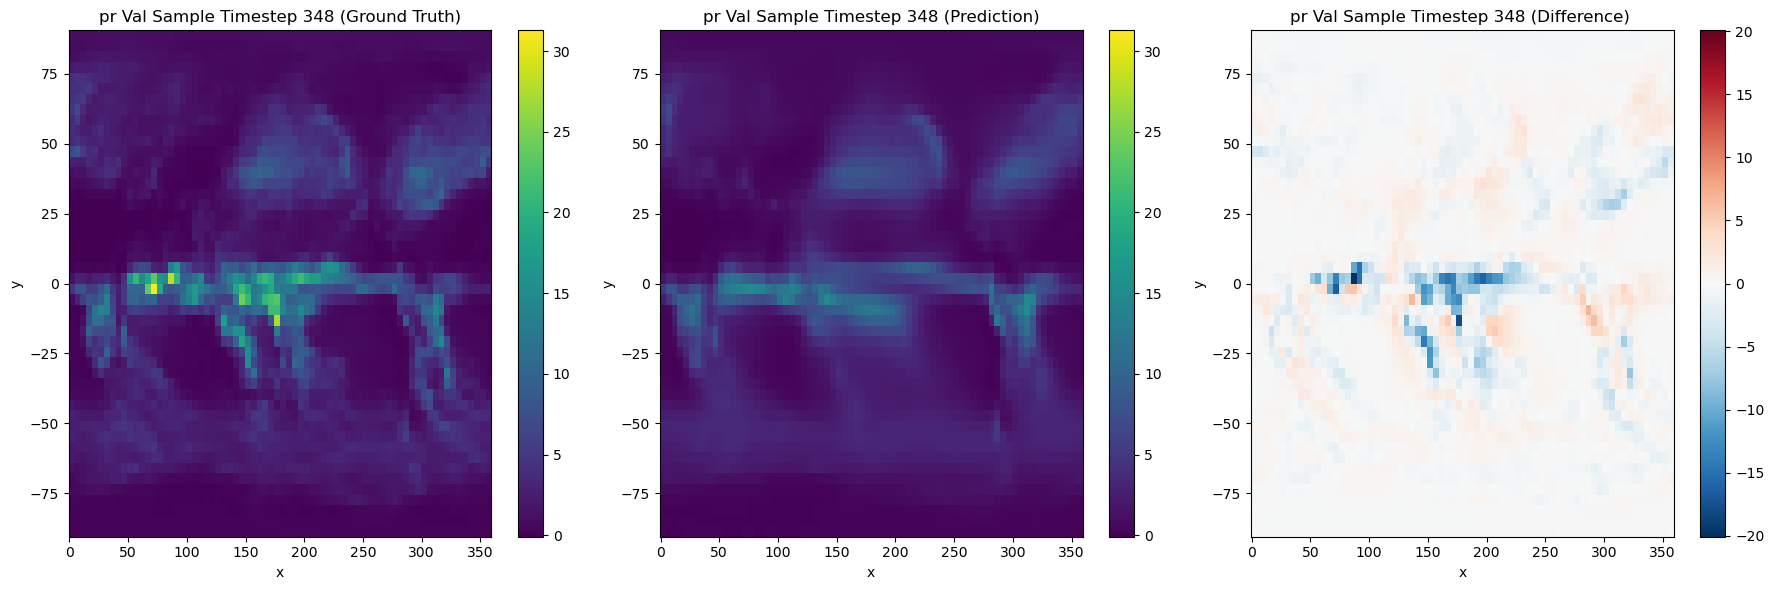

In [28]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!


In [ ]:
# import os, glob, matplotlib.pyplot as plt
# from tensorboard.backend.event_processing import event_accumulator as ea

# # ❶ Locate latest lightning run
# log_root = "lightning_logs"
# run_dir  = sorted(glob.glob(os.path.join(log_root, "version_*")),
#                   key=os.path.getmtime)[35]

# print("run_dir is ", run_dir)

# # ❷ Create EventAccumulator
# acc = ea.EventAccumulator(run_dir, size_guidance={"scalars": 0})
# acc.Reload()

# print("Available scalar keys:")
# for t in acc.Tags()["scalars"]:
#     print(" •", t)


In [ ]:
# # pick tags from the printed list
# train_tag = "train/loss"        # training MSE per step
# val_tag   = "val/tas/rmse"      # validation tas RMSE per epoch

# train_vals = acc.Scalars(train_tag)
# val_vals   = acc.Scalars(val_tag)

# train_steps, train_y = zip(*[(e.step, e.value) for e in train_vals])
# val_steps,   val_y   = zip(*[(e.step, e.value)   for e in val_vals])

# plt.figure(figsize=(7,4))
# plt.plot(train_steps, train_y, label="train loss (MSE)", alpha=.75)
# plt.plot(val_steps,   val_y,   label="val tas RMSE", lw=2)
# plt.xlabel("Global step"); plt.ylabel("Loss / RMSE")
# plt.title("Training vs. Validation")
# plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import pytorch_lightning as pl

# class MetricCollector(pl.Callback):
#     """
#     Collect per‑epoch metrics that ClimateEmulationModule logs via
#     self.log_dict({...}).  After training you can call
#     `collector.plot("val/tas/rmse")` to visualise the curve.
#     """
#     def __init__(self):
#         super().__init__()
#         self.history = {}          # {metric_name: [v0, v1, …]}

#     # called at the end of *every* validation epoch
#     def on_validation_epoch_end(self, trainer, pl_module):
#         logged = trainer.callback_metrics  # Dict[str, Tensor]
#         for k, v in logged.items():
#             if not isinstance(v, (int, float)):      # ignore tensors
#                 v = v.item()
#             self.history.setdefault(k, []).append(v)

#     # quick helper to plot any metric that was logged
#     def plot(self, tag_pattern="val/tas/rmse"):
#         assert tag_pattern in self.history, f"{tag_pattern} not logged."
#         y = self.history[tag_pattern]
#         x = range(1, len(y)+1)
#         plt.figure(figsize=(6,4))
#         plt.plot(x, y, marker="o")
#         plt.xlabel("validation epoch")
#         plt.ylabel(tag_pattern)
#         plt.title(f"{tag_pattern} over epochs")
#         plt.grid(True); plt.tight_layout()
#         plt.show()


# # ---------------- HOW TO USE ----------------
# # 1. Create the callback
# collector = MetricCollector()

# # 2. Pass it to the Trainer
# # trainer = pl.Trainer(max_epochs=15, callbacks=[collector], ...)

# # 3. After trainer.fit(...) finishes run:
# # collector.plot("val/tas/rmse")



In [ ]:
# trainer = pl.Trainer(max_epochs=15, callbacks=[collector])

In [ ]:
# collector.plot("val/tas/rmse")